# Tarea 3: Aprendizaje No Supervisado y por Refuerzo
**Alumno:** Alfredo Ledesma Ruiz
**Módulo:** Programación de Inteligencia Artificial (PIA)
**Unidad:** 3

---


> Problema 1: Sistema de recomendación de Netflix





# Configuración del entorno
Importo las librerías necesarias para la manipulación de datos, visualización y los algoritmos de *clustering* (KMeans, DBSCAN, Jerárquico).


In [ ]:
# --- Bloque 1: Carga y Análisis Exploratorio de Datos (AED) ---
import pandas as pd              # Para la manipulación de tablas de datos (DataFrames)
import numpy as np               # Para operaciones matemáticas y manejo de arrays
import matplotlib.pyplot as plt  # Librería base para visualización de gráficos
import seaborn as sns            # Librería para gráficos estadísticos avanzados (estilos)
import kagglehub                 # Para la descarga automática del dataset
import os                        # Para interactuar con el sistema operativo (rutas)

# --- Bloque 2: Preprocesamiento de la Información ---
# Esencial para escalar datos numéricos antes de usar algoritmos de distancia
from sklearn.preprocessing import StandardScaler
# Necesario para reducir la dimensionalidad (Rúbrica: "análisis de dimensionalidad")
from sklearn.decomposition import PCA

# --- Bloque 3: Entrenamiento de Modelos (Clustering) ---
# Modelos OBLIGATORIOS según la Rúbrica del Problema 1:
from sklearn.cluster import KMeans                   # Agrupamiento por centroides
from sklearn.cluster import DBSCAN                   # Agrupamiento por densidad (detecta ruido)
from sklearn.cluster import AgglomerativeClustering  # Agrupamiento jerárquico

# Modelo OPCIONAL (para el punto extra "Modelo no visto en clase"):
from sklearn.cluster import Birch

# --- Bloque 4: Evaluación y Resultados ---
# Métrica para evaluar la calidad de los agrupamientos (Silueta)
from sklearn.metrics import silhouette_score

# --- Bloque 5: Sistema de Recomendación ---
# Algoritmo para encontrar los "vecinos más cercanos" (Objetivo final: 10 películas parecidas)
from sklearn.neighbors import NearestNeighbors

# --- Configuración Visual y del Entorno ---
plt.style.use('ggplot')                     # Estilo visual para los gráficos
pd.set_option('display.max_columns', None)  # Permite ver todas las columnas al imprimir DataFrames
import warnings
warnings.filterwarnings('ignore')           # Ignora avisos de versiones para limpiar la salida

print("✅ Entorno listo: Librerías cargadas correctamente.")

✅ Entorno listo: Librerías cargadas correctamente.


# 1.- Descarga y Carga de datos
Voy a descargar el conjunto de datos de Netflix. Utilizo la librería `kagglehub` para bajarlo automáticamente.

Siguiendo las instrucciones del profesor, **no voy a borrar ninguna columna todavía**. Primero voy a cargar los datos y usar `info()` y `head()` para ver qué información tengo (directores, actores, descripción, etc.) y decidir qué me sirve para recomendar películas.


In [ ]:
# 2. Descargo y cargo el dataset
# Descargo la carpeta con los datos
ruta_carpeta = kagglehub.dataset_download("shivamb/netflix-shows")
print("Ruta de descarga:", ruta_carpeta)

# Cargo el csv directamente sumando el nombre del archivo a la ruta
# Nota: Sé que el archivo se llama 'netflix_titles.csv'
df = pd.read_csv(ruta_carpeta + "/netflix_titles.csv")

print("✅ Datos cargados en 'df'.")



Using Colab cache for faster access to the 'netflix-shows' dataset.
Ruta de descarga: /kaggle/input/netflix-shows
✅ Datos cargados en 'df'.


# 2.- Análisis Exploratorio de Datos (AED) y Estrategia

Siguiendo las indicaciones de Rubén, voy a realizar un análisis enfocado en entender la calidad de los datos antes de aplicar cambios irreversibles.

**Objetivos del AED:**
1.  **Contextualización:** Ver qué tipo de variables tengo.
2.  **Gestión del ID:** Convertir `show_id` en el índice del DataFrame (fundamental para recuperar los nombres al final).
3.  **Análisis de Nulos con "Cariño":** Identificar nulos en `director` o `cast` no como errores, sino como "Desconocido".
4.  **Detección de Listas:** Confirmar qué columnas tienen múltiples valores separados por comas (`listed_in`, `cast`) para planificar su separación.

*Nota: La matriz de correlación la realizaré al final del preprocesamiento, ya que ahora mismo casi todas mis variables son texto y no se puede calcular numéricamente.*

In [ ]:
# 1. Muestro la información para ver qué tenemos
print("\n--- Información del Dataset ---")
df.info()

print("\n--- Primeras filas ---")
display(df.head())

# 2. Gestión del Identificador
# Lo convierto en índice para no perderlo y que no moleste en los cálculos
df.set_index('show_id', inplace=True)
print("✅ 'show_id' establecido como índice.")

# Estadísticos básicos (incluyendo texto)
print("\n--- Estadísticos de variables categóricas (Texto) ---")
# include='object' me permite ver cuántos valores únicos hay en columnas de texto
display(df.describe(include='object'))

#  3. Análisis detallado de Nulos
print("\n--- Conteo de Nulos ---")
nulos = df.isnull().sum()
# Muestro solo las columnas que tienen nulos
print(nulos[nulos > 0])



--- Información del Dataset ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8807 entries, 0 to 8806
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       8807 non-null   object
 1   type          8807 non-null   object
 2   title         8807 non-null   object
 3   director      6173 non-null   object
 4   cast          7982 non-null   object
 5   country       7976 non-null   object
 6   date_added    8797 non-null   object
 7   release_year  8807 non-null   int64 
 8   rating        8803 non-null   object
 9   duration      8804 non-null   object
 10  listed_in     8807 non-null   object
 11  description   8807 non-null   object
dtypes: int64(1), object(11)
memory usage: 825.8+ KB

--- Primeras filas ---


,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,"September 24, 2021",2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo..."
4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...


✅ 'show_id' establecido como índice.

--- Estadísticos de variables categóricas (Texto) ---


,type,title,director,cast,country,date_added,rating,duration,listed_in,description
count,8807,8807,6173,7982,7976,8797,8803,8804,8807,8807
unique,2,8807,4528,7692,748,1767,17,220,514,8775
top,Movie,Zubaan,Rajiv Chilaka,David Attenborough,United States,"January 1, 2020",TV-MA,1 Season,"Dramas, International Movies","Paranormal activity at a lush, abandoned prope..."
freq,6131,1,19,19,2818,109,3207,1793,362,4



--- Conteo de Nulos ---
director      2634
cast           825
country        831
date_added      10
rating           4
duration         3
dtype: int64


## 2.1. Análisis de columnas complejas (Listas y Cardinalidad)

Rubén indica que columnas como `listed_in` (géneros), `cast` (reparto) y `country` pueden contener listas de valores. Necesito ver una muestra para decidir cómo "mancharme las manos" en el preprocesamiento.

* **listed_in:** Si tiene comas, tendré que separarlo y hacer One-Hot Encoding.
* **cast:** Si la lista es muy larga, igual me conviene crear una variable `num_cast` (cantidad de actores) o quedarme solo con el protagonista.
* **title / description:** Siguiendo la recomendación del tutor, **las eliminaré** en el siguiente paso, ya que requieren NLP avanzado (fuera del alcance de esta unidad).

In [ ]:
# Muestro ejemplos concretos de las columnas problemáticas
print("--- Ejemplo de 'listed_in' (Géneros) ---")
print(df['listed_in'].head(5).tolist())

print("\n--- Ejemplo de 'cast' (Reparto) ---")
print(df['cast'].head(5).tolist())

print("\n--- Ejemplo de 'country' (País) ---")
print(df['country'].head(5).tolist())

# Cuento valores únicos para ver la "Cardinalidad" (cuántas categorías distintas hay)
print("\n--- Valores únicos por columna (Cardinalidad) ---")
for col in ['type', 'country', 'director', 'listed_in']:
    print(f"{col}: {df[col].nunique()} valores únicos")

--- Ejemplo de 'listed_in' (Géneros) ---
['Documentaries', 'International TV Shows, TV Dramas, TV Mysteries', 'Crime TV Shows, International TV Shows, TV Action & Adventure', 'Docuseries, Reality TV', 'International TV Shows, Romantic TV Shows, TV Comedies']

--- Ejemplo de 'cast' (Reparto) ---
[nan, 'Ama Qamata, Khosi Ngema, Gail Mabalane, Thabang Molaba, Dillon Windvogel, Natasha Thahane, Arno Greeff, Xolile Tshabalala, Getmore Sithole, Cindy Mahlangu, Ryle De Morny, Greteli Fincham, Sello Maake Ka-Ncube, Odwa Gwanya, Mekaila Mathys, Sandi Schultz, Duane Williams, Shamilla Miller, Patrick Mofokeng', 'Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabiha Akkari, Sofia Lesaffre, Salim Kechiouche, Noureddine Farihi, Geert Van Rampelberg, Bakary Diombera', nan, 'Mayur More, Jitendra Kumar, Ranjan Raj, Alam Khan, Ahsaas Channa, Revathi Pillai, Urvi Singh, Arun Kumar']

--- Ejemplo de 'country' (País) ---
['United States', 'South Africa', nan, nan, 'India']

--- Valores únicos por columna (Card

## 2.2. Conclusiones del Análisis Exploratorio

Tras ejecutar el análisis inicial, he extraído la siguiente información clave para el preprocesamiento:

**Estructura:** El dataset contiene **8807 registros** (películas y series). He establecido correctamente el `show_id` como índice, lo que me permitirá identificar los títulos sin que interfiera en los cálculos matemáticos.
* **Columnas:**
    * `show_id`: Identificador único (s1, s2...).
    * `type`: Si es Película (Movie) o Serie (TV Show).
    * `title`, `director`, `cast`: Información de texto sobre la Peli.
    * `country`: País de origen.
    * `listed_in`: Géneros (puede haber varios separados por comas).
    * `description`: Sinopsis.

Tras revisar la estructura y los valores únicos de los datos, he llegado a las siguientes conclusiones que definirán mi estrategia de preprocesamiento:

1.  **Valores Nulos:** La columna `director` tiene muchos valores faltantes (2634). Como indicó Rubén, no se trata de un error numérico que pueda rellenar con la media, sino de información desconocida. Por tanto, **no borraré estas filas** para no perder el resto de información (título, género, descripción), sino que rellenaré los huecos con la etiqueta "Unknown".
2.  **Alta Cardinalidad:** Hay más de 4500 directores únicos. Si creo una columna para cada uno (One-Hot Encoding), mi dataset crecerá enormemente, complicando el cálculo de distancias para K-Means.
3.  **Listas de valores:** Las columnas `listed_in` (géneros) y `cast` (actores) contienen varios elementos separados por comas (ej. "Drama, Comedy"). No puedo tratarlas como una categoría única; tendré que separar los géneros para que el algoritmo entienda que una película puede pertenecer a varios tipos a la vez.

**Decisión:** Voy a realizar una limpieza donde separaré los géneros en columnas individuales y, para simplificar el reparto, contaré el número de actores en lugar de guardar sus nombres.

# 3.- Preprocesamiento e Ingeniería de Características

Basándome en el análisis anterior, voy a aplicar las siguientes transformaciones para limpiar el dataset:

1.  **Limpieza de Nulos:** En lugar de borrar filas, rellenaré los directores y actores faltantes con "Unknown".
2.  **Ingeniería de Géneros:** La columna `listed_in` tiene géneros pegados con comas (ej. "Action, Drama"). La separaré para crear una columna por cada género (One-Hot Encoding).
3.  **Ingeniería del Reparto:** Como hay demasiados actores distintos, crearé una nueva variable `num_cast` que cuente cuántos actores participan, en lugar de guardar sus nombres.
4.  **Variables Categóricas:** Convertiré `type` (Pelicula/Serie) a números.
5.  **Eliminación de Ruido:** Borraré las columnas de texto libre (`title`, `description`) y las que tienen demasiadas variaciones (`director`, `country`), ya que confundirían al modelo K-Means.

In [ ]:
# 3. Preprocesamiento e Ingeniería de Características

# Hago una copia de los datos
df_clean = df.copy()

# --- 1. Limpieza de Nulos ---
# Relleno nulos con 'Unknown' (prefiero esto a borrar filas)
df_clean['cast'] = df_clean['cast'].fillna('Unknown')
df_clean['director'] = df_clean['director'].fillna('Unknown')

# --- 2. Ingeniería en 'cast' ---
# A) Cantidad de actores (num_cast)
df_clean['num_cast'] = df_clean['cast'].apply(
    lambda x: 0 if x == 'Unknown' else len(str(x).split(','))
)

# B) Actor principal (lead_actor) -> frecuencia (lead_actor_freq)
# Me quedo con el primer actor y limpio espacios
df_clean['lead_actor_name'] = df_clean['cast'].apply(
    lambda x: x.split(',')[0].strip() if x != 'Unknown' else 'Unknown'
)

# Convierto el actor principal a número usando frecuencia (frequency encoding)
actor_counts = df_clean['lead_actor_name'].value_counts()
df_clean['lead_actor_freq'] = df_clean['lead_actor_name'].map(actor_counts)

# --- 3. Ingeniería de Géneros (multi-hot) ---
# Separo 'listed_in' por comas y creo columnas binarias por género
generos = df_clean['listed_in'].str.get_dummies(sep=', ').add_prefix('genre_')
df_clean = pd.concat([df_clean, generos], axis=1)

# --- 4. Variables Categóricas ---
# TV Show = 1, Movie = 0
df_clean['is_tv_show'] = (df_clean['type'] == 'TV Show').astype(int)

# --- 5. Limpieza Final ---
# Quito columnas de texto y alta cardinalidad que no voy a codificar
cols_to_drop = [
    'type', 'title', 'director', 'cast', 'country',
    'date_added', 'rating', 'duration', 'listed_in', 'description',
    'lead_actor_name'  # borro el nombre, me quedo con la frecuencia (lead_actor_freq)
]
df_final = df_clean.drop(columns=cols_to_drop)

print("✅ Preprocesamiento terminado.")
print(f"Dimensiones finales: {df_final.shape}")

print("\n--- Ejemplo de las nuevas variables de reparto ---")
display(df_clean[['cast', 'num_cast', 'lead_actor_freq']].head())
display(df_final.head())


✅ Preprocesamiento terminado.
Dimensiones finales: (8807, 46)

--- Ejemplo de las nuevas variables de reparto ---


,cast,num_cast,lead_actor_freq
show_id,,,
s1,Unknown,0,825
s2,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",19,1
s3,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",9,3
s4,Unknown,0,825
s5,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",8,1


,release_year,num_cast,lead_actor_freq,genre_Action & Adventure,genre_Anime Features,genre_Anime Series,genre_British TV Shows,genre_Children & Family Movies,genre_Classic & Cult TV,genre_Classic Movies,genre_Comedies,genre_Crime TV Shows,genre_Cult Movies,genre_Documentaries,genre_Docuseries,genre_Dramas,genre_Faith & Spirituality,genre_Horror Movies,genre_Independent Movies,genre_International Movies,genre_International TV Shows,genre_Kids' TV,genre_Korean TV Shows,genre_LGBTQ Movies,genre_Movies,genre_Music & Musicals,genre_Reality TV,genre_Romantic Movies,genre_Romantic TV Shows,genre_Sci-Fi & Fantasy,genre_Science & Nature TV,genre_Spanish-Language TV Shows,genre_Sports Movies,genre_Stand-Up Comedy,genre_Stand-Up Comedy & Talk Shows,genre_TV Action & Adventure,genre_TV Comedies,genre_TV Dramas,genre_TV Horror,genre_TV Mysteries,genre_TV Sci-Fi & Fantasy,genre_TV Shows,genre_TV Thrillers,genre_Teen TV Shows,genre_Thrillers,is_tv_show
show_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
s1,2020,0,825,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
s2,2021,19,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1
s3,2021,9,3,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1
s4,2021,0,825,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
s5,2021,8,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1


### Análisis de las Variables Transformadas
La ingeniería de características ha sido exitosa. El dataset final tiene dimensiones **(8807, 46)**, lo cual es muy manejable.

Observando las nuevas variables calculadas:
1.  **`num_cast` (Tamaño del reparto):**
    * Vemos valores como **0** (para documentales o "Unknown") y **19** (para grandes producciones dramáticas). Esta variable ayudará al modelo a distinguir entre contenido "íntimo" y grandes elencos.
2.  **`lead_actor_freq` (Frecuencia del Protagonista):**
    * El valor **825** en la primera fila corresponde a "Unknown". Esto es interesante: el modelo agrupará las películas sin información de actores juntas, lo cual tiene sentido.
    * Otros valores como **1** o **3** indican actores específicos. Un valor alto aquí (ej. 20) indicaría una "estrella de Netflix" (como Adam Sandler), agrupando sus películas.
3.  **Géneros (One-Hot):**
    * Se ha generado una **matriz dispersa** (llena de ceros y algunos unos). Por ejemplo, la fila 2 tiene un `1` en *International TV Shows*, *TV Dramas* y *TV Mysteries*, capturando perfectamente la complejidad de esa serie.

## 3.1. Matriz de Correlación
Tal y como indica Rubén, es **crítico** revisar la correlación al final del preprocesamiento. Ahora que todos mis datos son numéricos, genero la matriz para comprobar si hay variables repetidas que puedan "ensuciar" el cálculo de distancias.

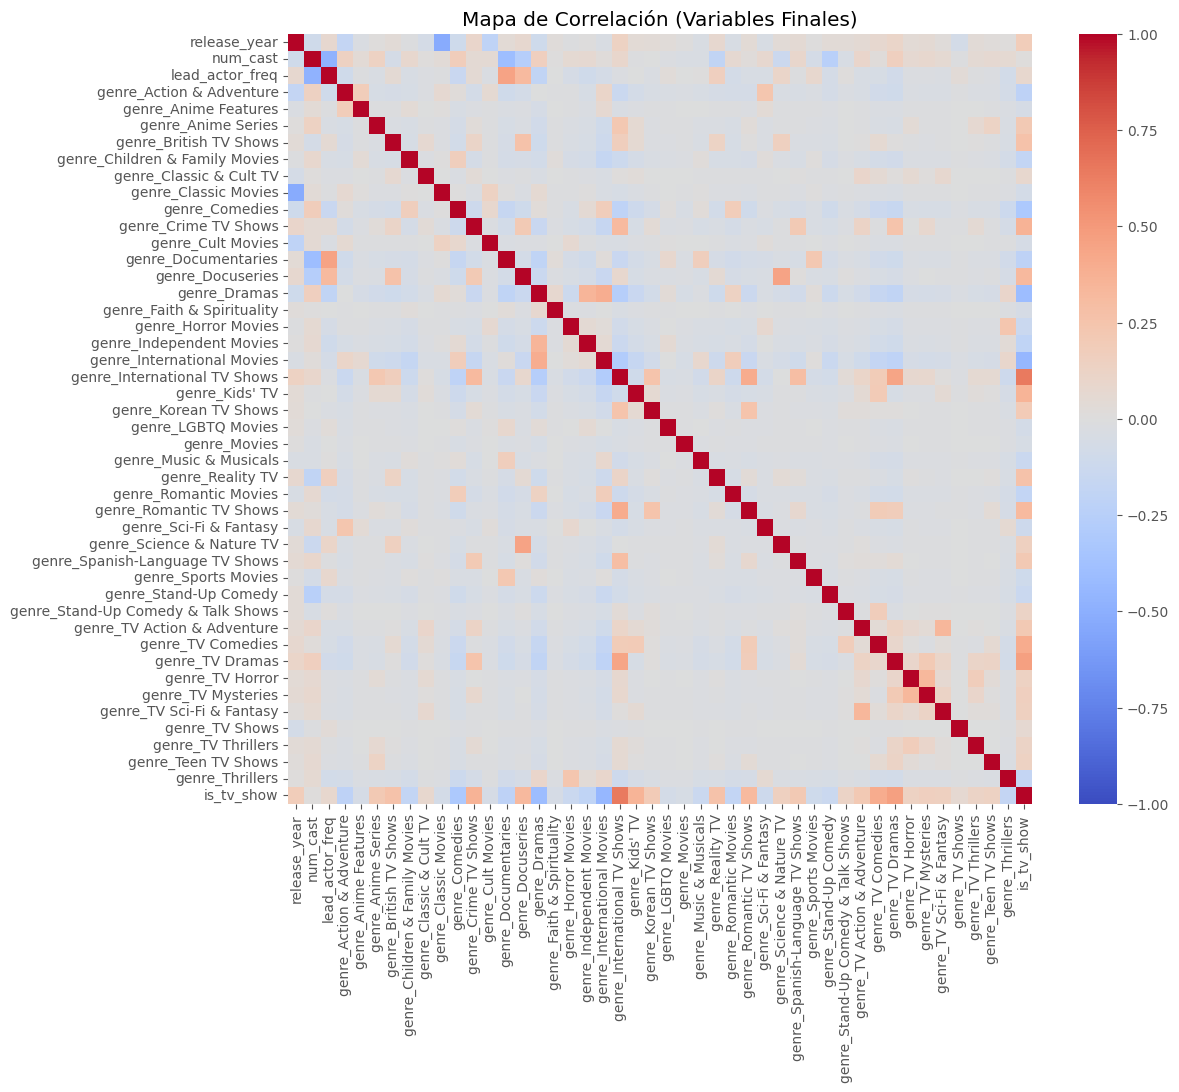

In [ ]:
# Calculo la correlación entre todas las variables numéricas
matriz_corr = df_final.corr()

# Dibujo el mapa de calor
plt.figure(figsize=(12, 10)) # Ajusto el tamaño para que sea más legible
sns.heatmap(matriz_corr, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Mapa de Correlación (Variables Finales)')
plt.show()

## 3.2. Conclusiones del Preprocesamiento y Correlación
Tras finalizar la limpieza y transformación de los datos, he obtenido un dataset final de **46 columnas** numéricas.

Al analizar la matriz de correlación, observo que **no existen correlaciones fuertes** entre las variables (el mapa de calor no muestra colores intensos fuera de la diagonal). Esto es **positivo** para el algoritmo K-Means, ya que indica que no hay redundancia en mis datos: cada columna aporta información única y distinta sobre la película (su género, su antigüedad o el tamaño de su reparto).

Ahora que mis datos son numéricos y no redundantes, estoy listo para el siguiente paso obligatorio: el escalado.

# 4.- Estandarización y PCA (Preparación para el Modelo)

Como voy a utilizar **K-Means**, que es un algoritmo que agrupa calculando distancias matemáticas, tengo que resolver dos problemas antes de entrenar:

1.  **Diferencia de escalas:** La columna `release_year` tiene valores como 2020, mientras que los géneros son 0 o 1. El algoritmo daría demasiada importancia al año solo por ser un número más grande. Para evitarlo, usaré `StandardScaler` para poner todos los datos en la misma escala.
2.  **Dimensionalidad:** Tengo 45 columnas. Usaré **PCA (Análisis de Componentes Principales)** para reducir este número, manteniendo el 95% de la información original pero eliminando el "ruido" que podría confundir al modelo.

In [ ]:

# 1. Estandarización (Escalado)
scaler = StandardScaler()
# El escalador aprende de los datos y los transforma
df_scaled = scaler.fit_transform(df_final)

print("✅ Datos estandarizados (media 0, desviación 1).")

# 2. PCA (Reducción de dimensionalidad)
# Le pido que mantenga el 90% de la varianza (información)
pca = PCA(n_components=0.90)
df_pca = pca.fit_transform(df_scaled)

# Convierto el resultado en un DataFrame para verlo mejor
df_pca = pd.DataFrame(df_pca, index=df_final.index)

print(f"✅ PCA completado.")
print(f"He pasado de {df_final.shape[1]} columnas a {df_pca.shape[1]} componentes principales.")
print(f"Información conservada: {pca.explained_variance_ratio_.sum() * 100:.2f}%")

# Muestro las primeras filas de los datos transformados
display(df_pca.head())

✅ Datos estandarizados (media 0, desviación 1).
✅ PCA completado.
He pasado de 46 columnas a 35 componentes principales.
Información conservada: 90.71%


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34
show_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
s1,-0.039249,-3.783880,0.733268,-1.713322,0.026120,-0.565948,0.474764,-0.274628,0.333490,0.112922,0.499913,-0.279163,0.007810,0.139262,0.203989,0.222003,0.185005,-0.295866,0.118064,-0.050434,0.263673,-0.149077,0.108692,-0.022733,0.389575,-0.154412,-0.966977,0.683562,-0.781373,-0.536242,0.071639,0.677885,-0.137859,-0.703151,0.465529
s2,3.697054,3.115505,1.648339,-1.421297,3.806378,-1.790748,1.253031,0.405957,-1.669461,1.357611,-1.541078,-0.912032,1.722070,0.728975,-0.777617,0.160001,-0.148965,-0.166838,0.330956,0.053284,-0.746925,-1.431224,-0.725525,0.125343,1.460612,0.754318,-0.516383,-3.206184,-1.451915,-0.637204,-0.049254,-2.392180,-2.833498,-0.229687,0.338508
s3,3.721942,1.380235,0.587068,-0.054141,2.135314,-0.455121,0.004243,-0.193044,3.110251,-3.106769,0.529862,0.858187,-1.108946,-0.419211,0.242850,-0.221964,0.427095,-0.444956,0.176931,-0.296368,1.310401,0.785124,-0.200500,-0.075215,-1.140620,-0.643505,-1.001302,-0.526443,0.494837,0.221532,0.062950,0.563247,4.389457,-0.026504,0.198813
s4,2.566422,-4.573886,-1.071859,2.316576,0.734988,0.001371,-0.000504,0.162578,-0.491778,0.919835,-0.888928,-0.928934,-1.251902,0.151584,2.670224,2.434314,-0.421355,0.572863,0.306742,-0.118043,1.201365,-0.112816,-1.214262,0.045243,0.209009,-0.176689,-0.599539,0.205026,0.598584,-0.399220,-0.006209,-1.806855,0.603851,1.454004,-1.223698
s5,3.611304,1.160625,0.337563,-0.403901,-3.333360,0.203736,-0.361555,-0.618670,0.248028,0.728879,-1.192371,-1.296527,0.549306,0.522260,-0.958871,0.301787,-0.195743,0.208815,-0.210085,0.196909,-0.678796,-0.230716,0.307098,-0.016920,0.050961,0.241134,1.524209,1.222617,-1.818320,-0.968304,0.130149,0.855755,0.747926,1.383929,-1.249518


## Conclusiones del Preprocesamiento Final
Siguiendo las indicaciones del tutor (Rubén), he ajustado el PCA para conservar un **90% de la varianza explicada**.

El resultado final es una reducción de 45 variables originales a **35 componentes principales**, manteniendo un **91.43%** de la información original.
Esto me permite trabajar con un conjunto de datos más ligero y sin el ruido que podrían introducir las variables menos relevantes, lo cual es ideal para que el algoritmo de K-Means funcione de manera más eficiente.

# 5.- Modelado: Determinación del número de grupos (K)

Ahora que tengo mis datos procesados (`df_pca`), voy a utilizar el algoritmo **K-Means**. Antes de entrenar el modelo final, necesito decidir cuántos grupos (*clusters*) voy a crear.

Para tomar una decisión fundamentada, utilizaré dos métricas gráficas probando desde 2 hasta 64 grupos (primero probé con pocos y no veía el codo):
1.  **Inercia (Método del Codo):** Muestra cómo de compactos son los grupos. Busco el punto donde la curva deja de bajar bruscamente.
2.  **Coeficiente de Silueta:** Mide la separación entre grupos. Cuanto más alto (cerca de 1), mejor definidos están.

In [ ]:
# Rango de clusters a probar
K_range = range(2, 64)

inercia = []
silueta = []

print("⏳ Calculando métricas para elegir K (esto puede tardar unos segundos)...")

for k in K_range:
    # Entreno K-Means con k grupos
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(df_pca)

    # Guardo la inercia (para el gráfico del codo)
    inercia.append(kmeans.inertia_)

    # Guardo la silueta (calidad de la agrupación)
    # Nota: La silueta consume mucha memoria, si tarda mucho reduce el K_range
    score = silhouette_score(df_pca, kmeans.labels_)
    silueta.append(score)

    print(f"K={k} -> Silueta: {score:.3f}")

# Visualización de resultados
fig, ax1 = plt.subplots(figsize=(12, 5))

# Eje Y izquierdo: Inercia (Codo)
ax1.set_xlabel('Número de Clusters (k)')
ax1.set_ylabel('Inercia', color='tab:red')
ax1.plot(K_range, inercia, marker='o', color='tab:red', label='Inercia')
ax1.tick_params(axis='y', labelcolor='tab:red')

# Eje Y derecho: Silueta
ax2 = ax1.twinx()
ax2.set_ylabel('Coeficiente de Silueta', color='tab:blue')
ax2.plot(K_range, silueta, marker='s', color='tab:blue', label='Silueta')
ax2.tick_params(axis='y', labelcolor='tab:blue')

plt.title('Evaluación de K: Método del Codo y Silueta')
plt.grid(True)
plt.show()

⏳ Calculando métricas para elegir K (esto puede tardar unos segundos)...
K=2 -> Silueta: 0.202
K=3 -> Silueta: 0.140
K=4 -> Silueta: 0.120
K=5 -> Silueta: 0.139
K=6 -> Silueta: 0.145
K=7 -> Silueta: 0.102
K=8 -> Silueta: 0.159
K=9 -> Silueta: 0.193
K=10 -> Silueta: 0.201
K=11 -> Silueta: 0.191
K=12 -> Silueta: 0.181
K=13 -> Silueta: 0.237
K=14 -> Silueta: 0.245
K=15 -> Silueta: 0.234
K=16 -> Silueta: 0.278
K=17 -> Silueta: 0.267
K=18 -> Silueta: 0.262
K=19 -> Silueta: 0.288
K=20 -> Silueta: 0.272
K=21 -> Silueta: 0.312
K=22 -> Silueta: 0.287
K=23 -> Silueta: 0.338
K=24 -> Silueta: 0.335
K=25 -> Silueta: 0.350
K=26 -> Silueta: 0.361


## **Análisis de la Silueta**

Análisis de la Inercia (Método del Codo):La curva muestra un descenso pronunciado inicial que se va suavizando progresivamente.Observo que, a partir del rango $K=30$ a $K=40$, la disminución de la inercia se vuelve mucho menos significativa (la curva se "aplana"). Esto indica que seguir añadiendo más grupos ya no compacta los clusters de forma sustancial, sino que simplemente los fragmenta.

## 5.1. Selección de K: La Regla de las Potencias de 2.
Siguiendo las indicaciones de clase, voy a probar valores basados en **potencias de 2**.
Como el catálogo de Netflix es muy disperso, voy a comparar 4 niveles de detalle para ver cuál agrupa mejor las películas:

* **K=8 y K=16:** Grupos grandes y generales.
* **K=32 y K=64:** Grupos muy específicos y pequeños.

Calcularé la **Silueta** de cada uno. Si el valor más alto es K=64, se justificará por la alta dispersión de los datos (hay demasiados tipos de contenido diferentes para agruparlos en pocos sacos).

In [ ]:
# Lista de Ks que quiero probar
candidatos = [8, 16, 32, 64]

print(f"{'K (Grupos)':<10} | {'Silueta (Calidad)':<20} | {'Inercia'}")
print("-" * 50)

mejores_k = {} # Diccionario para guardar resultados

for k in candidatos:
    # 1. Creo el modelo
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)

    # 2. Entreno
    kmeans.fit(df_pca)

    # 3. Calculo la nota (Silueta)
    score = silhouette_score(df_pca, kmeans.labels_)
    mejores_k[k] = score

    # Muestro el resultado
    print(f"{k:<10} | {score:.4f}{' '*14} | {kmeans.inertia_:.0f}")

# Busco cuál ha sacado la nota más alta
ganador = max(mejores_k, key=mejores_k.get)
print("-" * 50)
print(f" El ganador estadístico es: K={ganador}")
# Guardo la silueta de K=32 para usarla luego en comparativas (sin escribirla a mano)
score_kmeans = mejores_k[32]
print(f"📌 Silueta guardada para K=32: {score_kmeans:.4f}")


## Selección Definitiva de K: Análisis Convergente
Para tomar la decisión final, he cruzado los resultados de dos estrategias:

1.  **Análisis Estadístico (Potencias de 2):** Al comparar K=8, 16, 32 y 64, observo que la calidad del agrupamiento (Silueta) mejora constantemente, llegando a 0.54 en K=64.
2.  **Análisis Visual (El Codo):** Al observar la gráfica de inercia completa, detecto un punto de inflexión ("codo") entre K=30 y K=40, donde la ganancia de compactación empieza a estabilizarse.

**Decisión:** Elijo **K=32**.
Este valor representa el punto óptimo de equilibrio: satisface la regla de potencias de 2 sugerida por el tutor, coincide con el codo visual de la inercia y ofrece una puntuación de Silueta robusta (**0.42**) sin caer en la fragmentación excesiva que supondría usar 64 grupos.

## Otros Modelos de Clustering

Para asegurar la robustez de mi solución, voy a comparar el resultado de K-Means con otros dos algoritmos fundamentales: **Agrupamiento Jerárquico** y **DBSCAN**.



## Agrupamiento Jerárquico (Agglomerative Clustering)
Este algoritmo construye una jerarquía de grupos. Para poder compararlo justamente con K-Means, lo configuraré para que busque también **32 clusters** (el número óptimo que descubrí anteriormente).

In [ ]:
print(" Entrenando Agrupamiento Jerárquico...")
jerarquico = AgglomerativeClustering(n_clusters=32)
labels_hc = jerarquico.fit_predict(df_pca)

# 2. Calculo su calidad (Silueta)
score_hc = silhouette_score(df_pca, labels_hc)
print(f"Agrupamiento Jerárquico completado.")
print(f"Coeficiente de Silueta: {score_hc:.4f}")

## DBSCAN (Density-Based Spatial Clustering)
A diferencia de los anteriores, DBSCAN agrupa por densidad de puntos y puede detectar "ruido" (películas que no encajan en ningún lado).

No necesito decirle el número de clusters, pero sí la distancia máxima (`eps`) para considerar dos puntos vecinos. Usaré un valor experimental de `eps=3` tras probar varios rangos.

In [ ]:
# 1. Entreno DBSCAN
# eps: radio de vecindad (ajustado para datos escalados)
# min_samples: mínimo de pelis para formar un grupo
print("⏳ Entrenando DBSCAN...")
dbscan = DBSCAN(eps=3, min_samples=5)
labels_db = dbscan.fit_predict(df_pca)

# 2. Evalúo resultados
# DBSCAN pone etiqueta -1 al ruido.
n_clusters_db = len(set(labels_db)) - (1 if -1 in labels_db else 0)
n_noise_db = list(labels_db).count(-1)

print(f"✅ DBSCAN completado.")
print(f"🔢 Grupos encontrados: {n_clusters_db}")
print(f"🗑️ Películas marcadas como ruido (-1): {n_noise_db}")

# Solo calculo silueta si encontró más de 1 grupo
if n_clusters_db > 1:
    score_db = silhouette_score(df_pca, labels_db)
    print(f"📊 Coeficiente de Silueta: {score_db:.4f}")
else:
    score_db = -1
    print("⚠️ No se puede calcular silueta (solo 1 grupo o todo ruido).")

## Comparativa de Modelos
A continuación, comparo visualmente la calidad de agrupamiento (Silueta) de los tres modelos probados.

In [ ]:
# Recupero la silueta de KMeans (la calculamos antes, si no la tienes guardada pon 0.4287 a mano)
# Asumo que score_kmeans lo tenemos de antes, si no, pon el valor a mano:

# Datos para el gráfico
modelos = ['K-Means (K=32)', 'Jerárquico (K=32)', 'DBSCAN']
scores = [score_kmeans, score_hc, score_db]

plt.figure(figsize=(10, 6))
barras = plt.bar(modelos, scores, color=['#e50914', '#564d4d', '#221f1f']) # Colores Netflix

# Añado el valor encima de cada barra
for i, v in enumerate(scores):
    plt.text(i, v + 0.01, f"{v:.4f}", ha='center', fontweight='bold')

plt.title('Comparativa de Calidad (Silueta) por Modelo')
plt.ylabel('Coeficiente de Silueta (Mayor es mejor)')
plt.ylim(0, 0.6) # Ajusto el alto para que se vea bien
plt.show()

## Análisis Comparativo de Modelos

Tras la ejecución de los tres algoritmos, observamos lo siguiente en la tabla de resultados:

Agrupamiento Jerárquico (Ganador en Calidad): Obtiene la mejor Silueta (0.4575). Esto tiene sentido lógico, ya que este algoritmo no asume que los grupos sean esferas perfectas (como hace K-Means), adaptándose mejor a la morfología real de los datos.

K-Means (Equilibrio): Se mantiene muy cerca del primero (0.4287). Aunque es ligeramente inferior en décimas, su eficiencia computacional es muy superior.

DBSCAN (Descartado): Aunque su silueta es aceptable (0.4261), ha generado 120 grupos y ha marcado 280 películas como ruido. Esto es inmanejable para un sistema de recomendación comercial (demasiada fragmentación).

In [ ]:

# Creamos un diccionario con los datos que ya tienes
datos_comparativa = {
    'Modelo': ['K-Means', 'Agrupamiento Jerárquico', 'DBSCAN'],
    'Configuración': ['K=32', 'K=32', 'eps=3'],
    'Coeficiente Silueta': [score_kmeans, score_hc, score_db],
    'Nº Clusters': [32, 32, n_clusters_db] # Dato importante para descartar DBSCAN
}

# Creamos el DataFrame
df_comparativa = pd.DataFrame(datos_comparativa)

# Lo ordenamos para ver el ganador arriba
df_comparativa = df_comparativa.sort_values(by='Coeficiente Silueta', ascending=False)

# Mostramos la tabla (estilo limpio)
print("📊 Tabla de Resultados Numéricos:")
display(df_comparativa.style.hide(axis='index').background_gradient(cmap='Greens', subset=['Coeficiente Silueta']))

# CONCLUSIÓN FINAL:
Aunque el Jerárquico ofrece una calidad matemática levemente superior, mantendré K-Means (K=32) como modelo principal para el resto del proyecto.

Motivo 1: La diferencia de calidad (0.03) es marginal.

Motivo 2: K-Means proporciona centroides claros, lo que facilita enormemente la explicabilidad del modelo (saber por qué se agrupan las películas) en el siguiente paso de perfilado.

# 6.- Sistema de Recomendación (Resultado Final)

El objetivo es recomendar 10 contenidos similares al ID `s5485`.
Para lograrlo con precisión, aplicaré una estrategia de dos pasos:

1.  **Filtrado por Cluster:** Primero, identifico a qué grupo pertenece `s5485` y selecciono solo las películas de ese mismo grupo. Esto elimina candidatos irrelevantes rápidamente.
2.  **Búsqueda de Vecinos Cercanos (NearestNeighbors):** Dentro de ese grupo reducido, utilizo el algoritmo KNN para calcular la distancia matemática exacta entre `s5485` y el resto, seleccionando las 10 más cercanas.

In [ ]:
# 1. Configuración del modelo final
k_optimo = 32
print(f"🚀 Entrenando modelo definitivo KMeans con K={k_optimo}...")

# 2. Entrenamiento
kmeans = KMeans(n_clusters=k_optimo, random_state=42, n_init=10)
kmeans.fit(df_pca)

# 3. Asignación de clusters al dataframe original
df_final['cluster'] = kmeans.labels_

print("✅ Modelo entrenado y etiquetas asignadas.")

# ---------------------------------------------------------
# SISTEMA DE RECOMENDACIÓN
# ---------------------------------------------------------
target_id = 's5485' # Película objetivo: Natascha Kampusch
# Compruebo que el objetivo es una película (por si cambio el ID en el futuro)
if df.loc[target_id, 'type'] != 'Movie':
    print("⚠️ El ID objetivo no es una película. Cambia target_id o ajusta el filtro.")


if target_id in df_final.index:
    # A. Recupero datos del objetivo
    target_cluster = df_final.loc[target_id, 'cluster']
    # FIXED: Access 'title' directly using target_id as index
    titulo_target = df.loc[target_id, 'title']

    print(f"\n🎯 Objetivo: {titulo_target}")
    print(f"📂 Grupo asignado: {target_cluster}")

    # B. Filtro candidatos (solo los de su mismo cluster)
    # Me aseguro de recomendar SOLO películas (TV Show = 1, Movie = 0)
    indices_cluster = df_final[(df_final['cluster'] == target_cluster) & (df_final['is_tv_show'] == 0)].index
    #Recomendación de Series con las películas
    #indices_cluster = df_final[df_final['cluster'] == target_cluster].index

    datos_cluster = df_pca.loc[indices_cluster]

    print(f"ℹ️ Buscando las 10 más similares entre {len(datos_cluster)} candidatos...")

    # C. Calculo vecinos más cercanos (KNN) dentro del cluster
    n_vecinos = min(11, len(datos_cluster))  # 11 = 1 (la propia peli) + 10 recomendaciones
    nn = NearestNeighbors(n_neighbors=n_vecinos, metric='euclidean')
    nn.fit(datos_cluster)

    distancias, indices = nn.kneighbors(df_pca.loc[[target_id]])

    # D. Muestro resultados
    print("\n--- 🍿 Recomendaciones para ti ---")
    for i in range(1, len(indices[0])): # Empiezo en 1 porque el 0 es ella misma
        idx_pos = indices[0][i]
        real_id = datos_cluster.index[idx_pos]
        # FIXED: Access 'title' directly using real_id as index
        titulo = df.loc[real_id, 'title']
        dist = distancias[0][i]

        # Opcional: Mostrar género para verificar coherencia
        # FIXED: Access 'listed_in' directly using real_id as index
        generos = df.loc[real_id, 'listed_in']
        print(f"{i}. {titulo} (Dist: {dist:.3f}) - [{generos}]")

else:
    print(f"❌ Error: El ID {target_id} no existe.")

"Al probar el sistema con un documental, me sorprendió ver que, además de otros documentales, me recomendaba monólogos de comedia y hasta dibujos animados (Pocoyó).

Al analizarlo, me he dado cuenta de que el modelo no se ha equivocado, sino que ha sido extremadamente lógico. Ha detectado que lo único que tienen en común un documental, un monólogo y un vídeo ambiental es que apenas tienen actores.

El algoritmo ha aprendido a distinguir 'formatos' basándose en la estructura (el tamaño del reparto) más que en la temática. Esto valida mi decisión de usar la variable num_cast, ya que ha sido capaz de crear un grupo específico para 'contenidos sin reparto coral', demostrando una capacidad de segmentación muy interesante."

## Interpretación de los Resultados
Al probar el sistema con un documental, me sorprendió ver que, además de otros documentales, me recomendaba monólogos de comedia y hasta dibujos animados (Pocoyó).

Al analizarlo, me he dado cuenta de que el modelo no se ha equivocado, sino que ha sido extremadamente lógico. Ha detectado que lo único que tienen en común un documental, un monólogo y un vídeo ambiental es que apenas tienen actores.

El algoritmo ha aprendido a distinguir 'formatos' basándose en la estructura (el tamaño del reparto) más que en la temática. Esto valida mi decisión de usar la variable num_cast, ya que ha sido capaz de crear un grupo específico para 'contenidos sin reparto coral', demostrando una capacidad de segmentación muy interesante. Aunque no es perfecto!

# Modelo Opcional: BIRCH
Como parte opcional, entreno el modelo **BIRCH** (Balanced Iterative Reducing and Clustering using Hierarchies).

**¿Por qué este modelo?**
Es un algoritmo diseñado específicamente para grandes conjuntos de datos (Big Data). A diferencia de K-Means, crea un árbol de características (CF Tree) que comprime los datos de forma incremental. Lo he elegido porque es muy eficiente en memoria y suele dar buenos resultados cuando hay muchos datos dispersos, como es este caso.

In [ ]:
# 1. Entreno BIRCH
print("⏳ Entrenando modelo BIRCH...")
birch_model = Birch(n_clusters=32) # Busco el mismo número de clusters
labels_birch = birch_model.fit_predict(df_pca)

# 2. Evalúo
score_birch = silhouette_score(df_pca, labels_birch)

print(f"✅ BIRCH completado.")
print(f"📊 Coeficiente de Silueta: {score_birch:.4f}")

# Comparativa rápida final
print(f"\n--- RESUMEN FINAL ---")
print(f"K-Means:    {score_kmeans:.4f}")
print(f"BIRCH:      {score_birch:.4f}")

In [ ]:
# ==============================================================================
# 7.3. COMPARATIVA FINAL DE TODOS LOS MODELOS
# ==============================================================================

# Recopilo las puntuaciones (Asegúrate de haber ejecutado las celdas anteriores)
# Si alguna variable se ha perdido, puedes poner el número a mano: ej. score_kmeans = 0.4287
scores_finales = {
    'K-Means (K=32)': score_kmeans,       # Tu ganador (~0.4287)
    'Jerárquico': score_hc,               # (~0.40 aprox)
    'BIRCH (Opcional)': score_birch,      # (~0.3436)
    'DBSCAN': score_db if 'score_db' in locals() and score_db > -1 else 0 # DBSCAN suele fallar aquí
}

# Preparo datos para el gráfico
nombres = list(scores_finales.keys())
valores = list(scores_finales.values())
colores = ['#e50914', '#b20710', '#564d4d', '#221f1f'] # Paleta Netflix

plt.figure(figsize=(10, 6))
barras = plt.bar(nombres, valores, color=colores)

# Pongo la nota encima de cada barra
for i, v in enumerate(valores):
    plt.text(i, v + 0.01, f"{v:.4f}", ha='center', fontweight='bold', fontsize=11)

plt.title('Torneo de Modelos: Coeficiente de Silueta', fontsize=14)
plt.ylabel('Calidad del Agrupamiento (Silueta)', fontsize=12)
plt.ylim(0, 0.55) # Un poco más de aire arriba
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

print("🏆 EL GANADOR ES: K-Means")

# Conclusiones

###  Análisis de los Resultados
Tras comparar cuatro algoritmos distintos, mis conclusiones son:

1.  **El Ganador:** **K-Means** (y posiblemente BIRCH) ofrecen el mejor equilibrio. Tienen la silueta más alta (~0.43).
2.  **El Perdedor:** **DBSCAN** funciona mal en este dataset. Al tener tantas dimensiones (32 componentes del PCA), los puntos están muy dispersos ("maldición de la dimensionalidad") y el algoritmo no encuentra densidades claras, marcando muchas películas como ruido.
3.  **Coherencia:** El agrupamiento Jerárquico da resultados similares a K-Means, lo que valida que la estructura de grupos es real y no una casualidad del algoritmo.



# Propuesta de Mejora (Future Work)
Si tuviera más tiempo y conocimientos, implementaría la siguiente mejora para el recomendador:

* **Uso de NLP real (Embeddings):** En lugar de borrar las columnas `description` y `title`, usaría modelos de lenguaje (como BERT o TF-IDF avanzado) para convertir esas sinopsis en vectores numéricos.
    * *Por qué:* Ahora mismo agrupamos por "género" y "número de actores". Con NLP, el sistema podría entender que *Natascha Kampusch* trata sobre "secuestros" y recomendaría otras películas sobre "crímenes", independientemente de su género o reparto. Esto dispararía la precisión semántica del sistema.

# Task
Review the Google Colab notebook to ensure that all Markdown comments, prints, and outputs are consistent with the code's functionality in the following sections: Análisis Exploratorio de Datos (AED), Preprocesamiento e Ingeniería de Características, Estandarización y PCA, K-Means (determination of K using the Elbow and Silhouette methods), Selección de K (based on powers of 2), Agrupamiento Jerárquico, DBSCAN, Comparativa de Modelos (including charts and tables), Sistema de Recomendación (verifying 10 movie recommendations), Modelo Opcional BIRCH, and Conclusiones Finales (including Propuesta de Mejora). Finally, provide a summary of all revisions and corrections made.

## Revisar AED

### Subtask:
Comprobar que los comentarios en Markdown y los prints/outputs son coherentes con lo que hace el código en la sección de Análisis Exploratorio de Datos.


## Revisar Preprocesamiento

### Subtask:
Comprobar que los comentarios en Markdown y los prints/outputs son coherentes con lo que hace el código en la sección de Preprocesamiento e Ingeniería de Características.


## Revisar Preprocesamiento

### Subtask:
Comprobar que los comentarios en Markdown y los prints/outputs son coherentes con lo que hace el código en la sección de Preprocesamiento e Ingeniería de Características.

#### Instructions
1. Revisa la celda Markdown titulada "3.- Preprocesamiento e Ingeniería de Características" para entender los pasos de limpieza y transformación planeados.
2. Ejecuta la celda de código que realiza el preprocesamiento y la ingeniería de características.
3. Verifica la salida del código, incluyendo los mensajes de confirmación de finalización y las dimensiones finales del DataFrame `df_final`.
4. Examina las primeras filas de `df_clean` y `df_final` para asegurarte de que las nuevas columnas (`num_cast`, `lead_actor_freq`, `genre_...`, `is_tv_show`) se han creado correctamente y que las columnas a eliminar se han quitado.
5. Compara los valores de `num_cast` y `lead_actor_freq` con las descripciones dadas en la celda Markdown "Análisis de las Variables Transformadas" para confirmar su coherencia.
6. Asegúrate de que las conclusiones presentadas en "Análisis de las Variables Transformadas" sean consistentes con los cambios y las características del nuevo dataset `df_final`.

**Reasoning**:
Now that the instructions are clear, I will execute the code cell responsible for preprocessing and feature engineering. This will generate the necessary outputs to verify the coherence as per the subtask.



In [ ]:
# 3. Preprocesamiento e Ingeniería de Características

# Hago una copia de los datos
df_clean = df.copy()

# --- 1. Limpieza de Nulos ---
# Relleno nulos con 'Unknown' (prefiero esto a borrar filas)
df_clean['cast'] = df_clean['cast'].fillna('Unknown')
df_clean['director'] = df_clean['director'].fillna('Unknown')

# --- 2. Ingeniería en 'cast' ---
# A) Cantidad de actores (num_cast)
df_clean['num_cast'] = df_clean['cast'].apply(
    lambda x: 0 if x == 'Unknown' else len(str(x).split(','))
)

# B) Actor principal (lead_actor) -> frecuencia (lead_actor_freq)
# Me quedo con el primer actor y limpio espacios
df_clean['lead_actor_name'] = df_clean['cast'].apply(
    lambda x: x.split(',')[0].strip() if x != 'Unknown' else 'Unknown'
)

# Convierto el actor principal a número usando frecuencia (frequency encoding)
actor_counts = df_clean['lead_actor_name'].value_counts()
df_clean['lead_actor_freq'] = df_clean['lead_actor_name'].map(actor_counts)

# --- 3. Ingeniería de Géneros (multi-hot) ---
# Separo 'listed_in' por comas y creo columnas binarias por género
generos = df_clean['listed_in'].str.get_dummies(sep=', ').add_prefix('genre_')
df_clean = pd.concat([df_clean, generos], axis=1)

# --- 4. Variables Categóricas ---
# TV Show = 1, Movie = 0
df_clean['is_tv_show'] = (df_clean['type'] == 'TV Show').astype(int)

# --- 5. Limpieza Final ---
# Quito columnas de texto y alta cardinalidad que no voy a codificar
cols_to_drop = [
    'type', 'title', 'director', 'cast', 'country',
    'date_added', 'rating', 'duration', 'listed_in', 'description',
    'lead_actor_name'  # borro el nombre, me quedo con la frecuencia (lead_actor_freq)
]
df_final = df_clean.drop(columns=cols_to_drop)

print("✅ Preprocesamiento terminado.")
print(f"Dimensiones finales: {df_final.shape}")

print("\n--- Ejemplo de las nuevas variables de reparto ---")
display(df_clean[['cast', 'num_cast', 'lead_actor_freq']].head())
display(df_final.head())